# Дообучение Whisper для языка Хинди

## Вступление

Whisper - это предварительно обученная модель для автоматического распознавания речи (ASR).
Whisper предварительно обучается на огромном количестве размеченных аудиоданных с транскрипцией (около 680 000 часов). Около 117 000 часов этих данных для предварительного обучения - это многоязычные данные ASR
Whisper умеет распознавать аудио на 96 языках. Многие из этих языков являются малоресурсными.

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center">
Виспер это encoder-decoder модель, основанная на трансформерах. Такую модель также называют sequence-to-sequence. Она отображает последовательность признаков спектрограммы речи на последовательность текстовых токенов. Сначала исходные аудиовходы преобразуются в логарифмическую спектрограмму Мела с помощью извлекателя признаков. Затем трансформерный кодировщик кодирует спектрограмму, формируя последовательность скрытых состояний кодировщика. Наконец, декодер авторегрессивно предсказывает текстовые токены, основываясь как на предыдущих токенах, так и на скрытых состояниях кодировщика
</figure>



В модели sequence-to-sequence кодировщик преобразует аудиовходы в набор представлений скрытых состояний, извлекая важные признаки из произнесенной речи. Декодер играет роль языковой модели, обрабатывая представления скрытых состояний и генерируя соответствующие текстовые транскрипции. Включение языковой модели внутри системной архитектуры называется глубоким слиянием. Это противопоставляется поверхностному слиянию, при котором языковая модель комбинируется внешне с кодировщиком. При глубоком слиянии вся система может быть обучена end-to-end с одними и теми же данными и функцией потерь, что дает большую гибкость и, как правило, лучшую производительность

Whisper предобучается и дообучается с использованием функции потерь перекрестной энтропии, стандартной функции потерь для обучения систем sequence-to-sequence на задачах классификации. Здесь система обучается правильно классифицировать целевой текстовый токен из предопределенного словаря текстовых токенов.

Для модели Whisper существует пять контрольных точек различных размеров. Четыре самых маленьких обучены либо только на английском, либо на многоязычных данных. Самая большая контрольная точка является многоязычной.

| Size   | Layers | Width | Heads | Parameters | English-only                                         | Multilingual                                      |
|--------|--------|-------|-------|------------|------------------------------------------------------|---------------------------------------------------|
| tiny   | 4      | 384   | 6     | 39 M       | [✓](https://huggingface.co/openai/whisper-tiny.en)   | [✓](https://huggingface.co/openai/whisper-tiny.)  |
| base   | 6      | 512   | 8     | 74 M       | [✓](https://huggingface.co/openai/whisper-base.en)   | [✓](https://huggingface.co/openai/whisper-base)   |
| small  | 12     | 768   | 12    | 244 M      | [✓](https://huggingface.co/openai/whisper-small.en)  | [✓](https://huggingface.co/openai/whisper-small)  |
| medium | 24     | 1024  | 16    | 769 M      | [✓](https://huggingface.co/openai/whisper-medium.en) | [✓](https://huggingface.co/openai/whisper-medium) |
| large  | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large)  |

Я буду обучать small модель. Было решено выбрать один из малоресурных языков, а именно язык Хинди (распространен в северной Индии). Датасеты брал отсюда: https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0. Там около 12 часов размеченных данных для Хинди.

## Подготовка пакетов

Для загрузки и подготовки данных я использовал datasets, а также transformers и accelerate для загрузки и обучения модели. Также пакет soundfile использовался для предварительной обработки аудиофайлов, evaluate и jiwer для оценки производительности модели, и tensorboard для записи метрик. Демо сделано с помощью gradio

In [ ]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio

In [ ]:
from huggingface_hub import notebook_login

notebook_login("тут был мой токен")

## Загрузка данных

Здесь ничего сложного: пара строчек чтобы загрузить датасеты с помощью datasets

Для тренировки модели я объединил разделы "train" и "validation", так как данных мало.

In [ ]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_11_0", "hi", split="train+validation", use_auth_token=True)
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_11_0", "hi", split="test", use_auth_token=True)

print(common_voice)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You 

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 4361it [00:00, 31810.84it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 2179it [00:00, 19260.28it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 2894it [00:00, 48636.92it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 3328it [00:00, 61114.10it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 680it [00:00, 50588.46it/s]
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_11_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 6540
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 2894
    })
})


Видно, что эти датасеты содержат много дополнительных полей с информацией ("locale', "accent"). Обычно, ASR данные содержат только аудио и транскрибированный текст, так что остальные поля можно убрать.

In [ ]:
common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])

print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 6540
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 2894
    })
})


## Подготовка признаков, токенизатора и данных

Пайплайн ASR можно разделить на три части
1) Извлекатель признаков, который предварительно обрабатывает входные аудиоданные
2) Модель, которая выполняет маппинг sequence-to-sequence
3) Токенизатор, который занимается постобработктой выходных данных модели в текстовый формат

В пакете transformes для этого есть WhisperFeatureExtractor и WhisperTokenizer

### WhisperFeatureExtractor

Речь представляет собой одномерный массив, который меняется со временем. Значение массива в любой данной точке времени - это амплитуда сигнала в этой точке. Исходя только из информации об амплитуде, можно восстановить спектр частот аудио и восстановить все акустические признаки.

Т.к. речь непрерывна, она содержит бесконечное количество значений амплитуды, поэтому ее надо дискретизировать. Дискретизация происходит путем выбора значений из сигнала с фиксированными временными шагами. Отсюда появляется частота дискретизации. Выборка с более высокой частотой дискретизации приводит к лучшему приближению, но также требует хранения большего количества значений в секунду.

Whisper принимает аудио с частотой дискретизации 16 кГц, поэтому надо чтобы и входные данные имели такую частоту (иначе получится, что модель будет обучаться как бы на замедленной речи).

Whisper feature extractor выполняет 2 операции:
1. Делает так, чтобы все аудио имели длительность 30 секунд
2. Преобразует аудиомассив в спектрограмму Mel (что-то похожее на преобразование Фурье как я понял). Вдоль оси y находятся каналы Mel, которые соответствуют определенным частотным диапазонам. Вдоль оси x - время. Цвет каждого пикселя соответствует логарифмической интенсивности какой-либо частоты в данное время

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center">

WhisperFeatureExtractor выполняет эти операции в одну строчку.

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

### WhisperTokenizer

Whisper выводит текстовые токены, которые указывают индекс предсказанного текста среди словаря элементов словаря. Токенизатор сопоставляет последовательность текстовых токенов с фактической текстовой строкой (например, [1169, 3797, 3332] -> "the cat sat").
Т.к. у нас модель encoder-decoder, то можно взять токенизатор из уже обученной модели и просто указать целевой язык и задачу

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Hindi", task="transcribe")

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

### WhisperProcessor

Для упрощения использования можно объединить Tokenizer и FeatureExtractor в один класс WhisperProcessor. Он наследуется от WhisperFeatureExtractor и WhisperProcessor. Таким образом, нам нужно отслеживать только два объекта во время обучения: processor и model:

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Hindi", task="transcribe")

### Подготовка данных

Печатаю пример данных

In [ ]:
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/c090ee7e53af621f387a7ad442373c879defc9f799c91a68edc0f646c36f115f/hi_train_0/common_voice_hi_26008353.mp3', 'array': array([ 5.81611368e-26, -1.48634016e-25, -9.37040538e-26, ...,
        1.06425901e-07,  4.46416450e-08,  2.61450239e-09]), 'sampling_rate': 48000}, 'sentence': 'हमने उसका जन्मदिन मनाया।'}


Видно, что данные имеют частоту дискретизации 48 кГц, а виспер принимает 16 Кгц. Значит, надо поменять частоту

In [ ]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

То есть я указал нужную частоту, а в следующий раз, когда данные будут использоваться, эта частота применится к аудио (ниже видно что поменялась и частота и массив данных)

In [ ]:
print(common_voice["train"][0])

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/c090ee7e53af621f387a7ad442373c879defc9f799c91a68edc0f646c36f115f/hi_train_0/common_voice_hi_26008353.mp3', 'array': array([ 3.81639165e-17,  2.42861287e-17, -1.73472348e-17, ...,
       -1.30981789e-07,  2.63096808e-07,  4.77157300e-08]), 'sampling_rate': 16000}, 'sentence': 'हमने उसका जन्मदिन मनाया।'}


Теперь можно проделать описанные выше операции

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

Применяю ко всем данным, итерируясь по ним с помощью map()

In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)

Map (num_proc=2):   0%|          | 0/6540 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2894 [00:00<?, ? examples/s]

## Обучение и оценка

Дальше нужно:
1) Преобразовать данные в тензоры PyTorch (потому что виспер работает с ними)
2) Определить метрику
3) Сделать чекпоинт модели
4) Определить аргументы обучения

### Паддинг

input_features и labels обрабатываются независимо друг от друга. input_features уже размечены как надо, а labels - нет, поэтому их надо будет сдвинуть, чтобы они не учитывались при расчете ошибки

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

### Метрика

Для оценки моделей по распознаванию аудио используется метрика WER (Word Error rate). Она есть в пакете evaluate. Я в нее особо не вникал, но документация есть тут https://huggingface.co/spaces/evaluate-metric/wer

In [ ]:
import evaluate

metric = evaluate.load("wer")

Функция, которая считает метрику

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    label_ids[label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Чекпоинт

Загружаем чекпоинт с помощью transformers

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [ ]:
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

### Аргументы обучения

Определяю аргументы обучения (там указывается как часто будут сохранятся контрольные точки, как часто они будут оцениваться, максимальное кол-во токенов и т.д.). Я брал стандартные значения из документации к Seq2SeqTrainingArguments https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate>=0.21.0

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-hi",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

Передаю параметры в trainer

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

### Обучение

In [ ]:
trainer.train()

Получились вот такие результаты

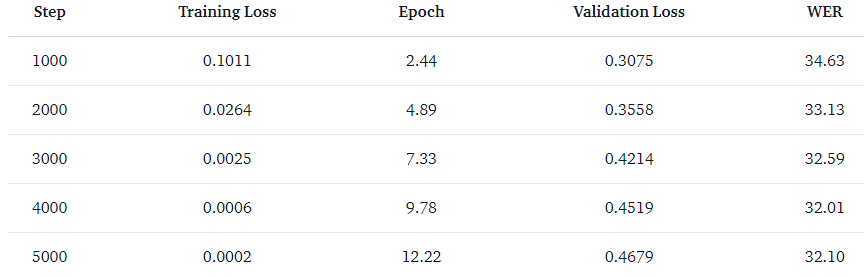

Сравним их с результатами стандартных моделей виспера

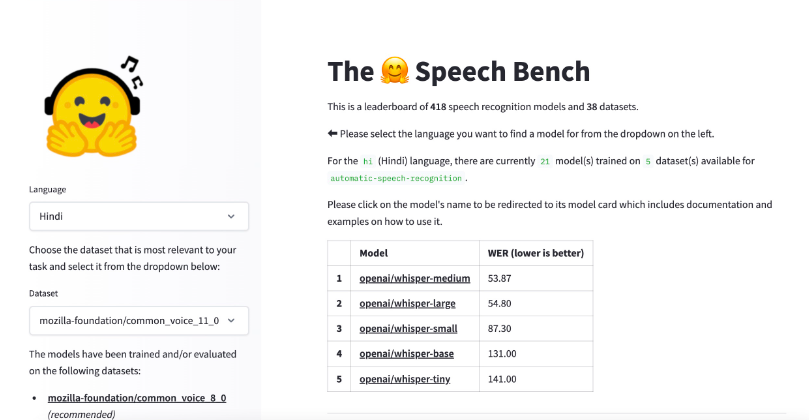

## Демо

Использую gradio чтобы продемонстрировать работу модели

In [9]:
!pip uninstall gradio
!pip install gradio==3.50.2
!pip uninstall torch
!pip install torch
!pip install transformers

Found existing installation: gradio 3.50.2
Uninstalling gradio-3.50.2:
  Would remove:
    /usr/local/bin/gradio
    /usr/local/bin/upload_theme
    /usr/local/lib/python3.10/dist-packages/gradio-3.50.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/gradio/*
Proceed (Y/n)? y
  Successfully uninstalled gradio-3.50.2
  Using cached gradio-3.50.2-py3-none-any.whl (20.3 MB)
Found existing installation: torch 2.1.2
Uninstalling torch-2.1.2:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/nvfuser/*
    /usr/local/lib/python3.10/dist-packages/torch-2.1.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? y
  Successfully uninstalled torch-2.1.2
  Using cached torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
ERROR: pip

In [5]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="untilSeven/whisper-small-hi")
def transcribe(audio):
    text = pipe(audio)["text"]
    return text

iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(source="microphone", type="filepath"),
    outputs="text",
    title="Whisper Small Хинди",
    description=None,
)

iface.launch()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3349addbe8867b7593.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
